In [1]:
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from copy import deepcopy
import torch
from tqdm.notebook import tqdm

from sklearn.neighbors import NearestNeighbors

from data import stratified_kfold
from utils import seed_everything

In [2]:
class Config:
    checkpoint = '/root/dl_whale_classification/pths_individual'
    test = False
    tta = False
    resume_epoch = 0
    iters_to_accumulate = 1
    resume_root = None
    wandb_log = True
    model_name = 'tf_efficientnet_b6_ns'
    fold = 0
    n_split = 5
    seed = 2022
    data_dir = '/root/data2/' # root/data/train_images
    root_dir = '.'
    batch_size = 8
    lr = 1e-4
    weight_decay = 0.0005
    epoch = 20
    exp_name = 'test'
config = Config()

In [3]:
seed_everything(2022)

In [4]:
df = pd.read_csv('/root/data/train.csv')
df = df.iloc[:len(df)]
df.species.replace({"globis": "short_finned_pilot_whale",
                  "pilot_whale": "short_finned_pilot_whale",
                  "kiler_whale": "killer_whale",
                  "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

In [5]:
specie_unique = df.species.unique()
specie_indices = range(len(specie_unique))
species2idx = {k: v for k, v in zip(specie_unique, specie_indices)}
df.species = df.species.map(species2idx)

individual_unique = df.individual_id.unique()
individual_indices = range(len(individual_unique))
individual2idx = {k : v for k, v in zip(individual_unique, individual_indices)}
idx2individual = {k:v for v,k in individual2idx.items()}
df.individual_id = df.individual_id.map(individual2idx)

In [6]:
individual2idx

{'cadddb1636b9': 0,
 '1a71fbb72250': 1,
 '60008f293a2b': 2,
 '4b00fe572063': 3,
 '8e5253662392': 4,
 'b9907151f66e': 5,
 'afb9b3978217': 6,
 '444d8894ccc8': 7,
 'df94b15285b9': 8,
 'b11b2404c7e3': 9,
 '19fbb960f07d': 10,
 '180c0ab04dcd': 11,
 '0ad50d0d9b06': 12,
 '812be36c2aef': 13,
 '445270d9ad52': 14,
 '4790ec346170': 15,
 'bc14b5054353': 16,
 'ff69d0975a73': 17,
 '780fefdb6198': 18,
 'a8c9dfb8ac6f': 19,
 '6c4372e42db1': 20,
 '35f898e6595e': 21,
 'bfb74132d1db': 22,
 '114207cab555': 23,
 '3cbfd98eea8f': 24,
 'f5eab86405b4': 25,
 '956562ff2888': 26,
 'c27f0a7f4e5a': 27,
 'f7bb4f9a9d1a': 28,
 'e943980b7a98': 29,
 '45fc3a8e1d4e': 30,
 '1816cc1ae38b': 31,
 'a21288153152': 32,
 'a03830613b45': 33,
 'fefd0899a5dc': 34,
 '6348a7ef0d99': 35,
 'e69d5f9f8d1e': 36,
 '90c9eaca0927': 37,
 '5ca799f80b5e': 38,
 '92ff817f9805': 39,
 '456bb79da64c': 40,
 '2842789d601d': 41,
 'cab2ce1793f2': 42,
 '3e025417eb83': 43,
 'fcc405e10c09': 44,
 'e6388e8a7f58': 45,
 'ede6a5ed0100': 46,
 '37c7aba965a5': 47,
 '

In [7]:
df_single = df[df['individual_id'].map(df['individual_id'].value_counts()) == 1]
df_others = df[df['individual_id'].map(df['individual_id'].value_counts()) > 1]

In [90]:
fold = 4

In [91]:
train_single, valid_single = stratified_kfold(df=df_single, fold=fold, n_split=config.n_split, seed=config.seed, target_col='species')
train_others, valid_others = stratified_kfold(df=df_others, fold=fold, n_split=config.n_split, seed=config.seed, target_col='individual_id')

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [112]:
len(full_valid_indices)

9503

In [92]:
train_single_indices = np.take(df_single.index.to_numpy(), train_single) # 실제 index    
train_others_indices = np.take(df_others.index.to_numpy(), train_others)
valid_single_indices = np.take(df_single.index.to_numpy(), valid_single)
valid_others_indices = np.take(df_others.index.to_numpy(), valid_others)

In [93]:
valid_single_indices = valid_single_indices[:1148]

In [94]:
full_train_indices = np.sort(np.concatenate((train_single_indices, train_others_indices), axis=0))
full_valid_indices = np.sort(np.concatenate((valid_single_indices, valid_others_indices), axis=0))

In [95]:
embeds_train = sorted(glob('/root/embeddings/220329_effn_m/*train*'))
embeds_test = sorted(glob('/root/embeddings/220329_effn_m/*test*'))

In [96]:
embed_train = torch.load(embeds_train[fold]).numpy()

In [97]:
neigh = NearestNeighbors(n_neighbors=1, metric='cosine')

In [98]:
neigh.fit(embed_train[full_train_indices])

NearestNeighbors(metric='cosine', n_neighbors=1)

# top3 체크 + 폴드별 thr 측정

In [99]:
distance1, indices1 = neigh.kneighbors(embed_train[valid_single_indices], n_neighbors=3, return_distance=True) # 80 %에 해당하는 index
distance2, indices2 = neigh.kneighbors(embed_train[valid_others_indices], n_neighbors=3, return_distance=True)

96

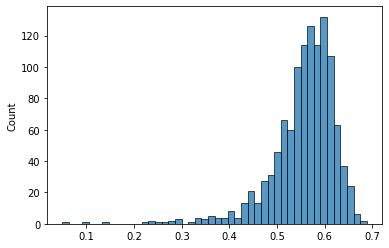

In [100]:
# single
neigh_trues = df.individual_id[valid_single_indices].values
sns.histplot(distance1[:,0])
(distance1[:,0] < 0.469).sum()

In [101]:
neigh_preds = np.array(df.individual_id[full_train_indices].values)[indices2[:,0].reshape(-1)] # k neighbor 예측값
neigh_trues = df.individual_id[valid_others_indices].values
correct1 = (neigh_preds == neigh_trues) # neigh 예측값중 맞은 index
wrong1 = (neigh_preds != neigh_trues)
print('min, mean, max (total):', distance2.min(), distance2.mean(), distance2.max())
print('min, mean, max (correct):', distance2[correct1].min(), distance2[correct1].mean(), distance2[correct1].max())
print('min, mean, max (wrong):', distance2[wrong1].min(), distance2[wrong1].mean(), distance2[wrong1].max())
print('correct %', len(distance2[correct1])/len(distance2), len(distance2[correct1]))
print('wrong %', len(distance2[wrong1])/len(distance2), len(distance2[wrong1]))

min, mean, max (total): 0.0001335144 0.26947594 0.707368
min, mean, max (correct): 0.0001335144 0.20217323 0.69712305
min, mean, max (wrong): 0.0044819117 0.51754856 0.707368
correct % 0.7865948533812088 6572
wrong % 0.21340514661879115 1783


In [102]:
neigh_preds = np.array(df.individual_id[full_train_indices].values)[indices2[:,1].reshape(-1)] # k neighbor 예측값
neigh_trues = df.individual_id[valid_others_indices].values
correct2 = (neigh_preds == neigh_trues) # neigh 예측값중 맞은 index
wrong2 = (neigh_preds != neigh_trues)
print('min, mean, max (total):', distance2.min(), distance2.mean(), distance2.max())
print('min, mean, max (correct):', distance2[correct2].min(), distance2[correct2].mean(), distance2[correct2].max())
print('min, mean, max (wrong):', distance2[wrong2].min(), distance2[wrong2].mean(), distance2[wrong2].max())
print('correct %', len(distance2[correct2])/len(distance2))
print('wrong %', len(distance2[wrong2])/len(distance2))

min, mean, max (total): 0.0001335144 0.26947594 0.707368
min, mean, max (correct): 0.0001335144 0.16635807 0.68718857
min, mean, max (wrong): 0.0044819117 0.5172949 0.707368
correct % 0.706163973668462
wrong % 0.293836026331538


In [103]:
neigh_preds = np.array(df.individual_id[full_train_indices].values)[indices2[:,2].reshape(-1)] # k neighbor 예측값
neigh_trues = df.individual_id[valid_others_indices].values
correct3 = (neigh_preds == neigh_trues) # neigh 예측값중 맞은 index
wrong3 = (neigh_preds != neigh_trues)
print('min, mean, max (total):', distance2.min(), distance2.mean(), distance2.max())
print('min, mean, max (correct):', distance2[correct3].min(), distance2[correct3].mean(), distance2[correct3].max())
print('min, mean, max (wrong):', distance2[wrong3].min(), distance2[wrong3].mean(), distance2[wrong3].max())
print('correct %', len(distance2[correct3])/len(distance2))
print('wrong %', len(distance2[wrong3])/len(distance2))

min, mean, max (total): 0.0001335144 0.26947594 0.707368
min, mean, max (correct): 0.0001335144 0.15093748 0.68718857
min, mean, max (wrong): 0.0044819117 0.51003426 0.707368
correct % 0.6698982645122681
wrong % 0.3301017354877319


In [116]:
distance2

array([[0.15303797, 0.17067051, 0.17560458],
       [0.08560318, 0.08702064, 0.08922946],
       [0.08340442, 0.09068924, 0.12001139],
       ...,
       [0.06225753, 0.0647229 , 0.06956792],
       [0.49553525, 0.53264785, 0.53533703],
       [0.02376282, 0.05522168, 0.08368021]], dtype=float32)

In [157]:
((wrong1 & wrong2) & correct3).sum()

79

<AxesSubplot:ylabel='Count'>

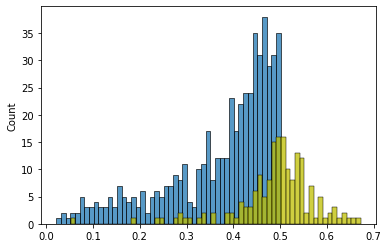

In [162]:
sns.histplot(distance2[wrong1][distance2[:,1][wrong1] < 0.5][:,1], binwidth=0.01) # top 2에 new 박는게 여기까진 최고 - 종분류 한다면?
sns.histplot(distance1[:,1][distance1[:,0] < 0.5], binwidth=0.01, color='y')

In [147]:
(distance1[:,0] < 0.5).sum()

174

In [143]:
(distance1[:,1][distance1[:,0] < 0.5] > 0.4).sum()

157

<AxesSubplot:ylabel='Count'>

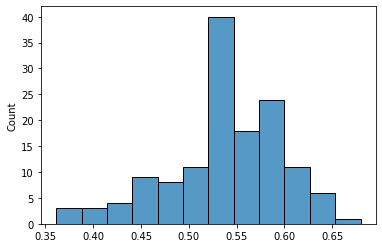

In [164]:
sns.histplot(distance2[:,1][wrong1 & correct2])

In [156]:
wrong1.sum()

1783

In [150]:
(wrong1 & correct2).sum() # specie 모델, 중복제거

138

In [152]:
(distance2[:,1][wrong1 & correct2]<0.4).sum() # distance로 판단을 하면 안된다

4

In [ ]:
new_individual 뿐

In [124]:
distance1

array([[0.5958041 , 0.6046119 , 0.61339945],
       [0.6186511 , 0.640058  , 0.64837235],
       [0.6093609 , 0.62670106, 0.6422485 ],
       ...,
       [0.60222656, 0.64454806, 0.648936  ],
       [0.6152868 , 0.64132416, 0.6492447 ],
       [0.550078  , 0.58347255, 0.59371686]], dtype=float32)

<AxesSubplot:ylabel='Count'>

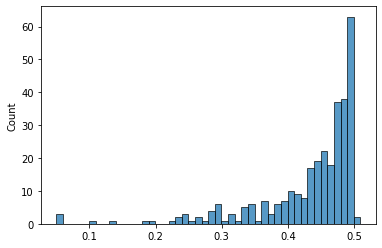

In [105]:
((wrong1 & wrong2) & correct3).sum()

79

In [106]:
# sns.histplot(distance2[:,0][correct1])
# plt.show()
# sns.histplot(distance2[:,0][wrong1])
# plt.show()
# sns.histplot(distance2[:,0])
# plt.show()
# sns.histplot(distance1[:,0])
# plt.show()

In [107]:
thr = 0.5100000000000001
(distance1[:,0] > thr).sum(), (distance2[:,0][correct1] > thr).sum(), (distance2[:,0][wrong1] > thr).sum()

(942, 295, 1046)

In [109]:
value = 1e9
best = 0
best_x = 0
best_y = 0
best_z = 0

value_ = 1e9 # 양방향 최소 차이
best_ = 0
best_x_ = 0
best_y_ = 0
for i in np.arange(0.40, 0.55, 0.001):
    thr = i # 0.455
    x,y,z = (distance2[:,0][correct1] > thr).sum(), (distance2[:,0][wrong1] > -1).sum(), (distance1[:,0] < thr).sum()
    if value > x+y+z:
        value = (x+y+z)
        best_x = x
        best_y = y
        best_z = z
        best = thr
    if value_ > x+z:
        value_ = x+z
        best_x_ = x
        best_z_ = z
        best_ = thr
best_, (best_x_, best_z_), value_, best, value, (best_x, best_y, best_z)

(0.5100000000000001,
 (295, 206),
 501,
 0.5100000000000001,
 2284,
 (295, 1783, 206))

In [278]:
thr = 0.03
(distance2[:,0][correct1] > thr).sum(), (distance2[:,0][wrong1] < thr).sum(), (distance1[:,0] < thr).sum()

(5596, 3, 1)

In [282]:
thr = 0.1
(distance2[:,0][correct1] < thr).sum(), (distance2[:,0][wrong1] < thr).sum(), (distance1[:,0] < thr).sum()

(3562, 17, 3)

# 1번 : 전체 데이터에 대한 test추론 후
# distance (id or image) 평균값으로 앙상블

In [238]:
len(full_valid_indices)

10207

기본 threshold   
fold0 thr : 0.501, (319, 274), 593
fold1 thr : 0.496, (364, 256), 620
fold2 thr : 0.508, (319, 333), 652
fold3 thr : 0.492, (349, 228), 577 --- 
fold4 thr : 0.508, (307, 328), 635 --- 138 79

괄호 안에 있는 애들이 전부 threshold 적용하면 틀리는 애들

In [202]:
neigh = NearestNeighbors(n_neighbors=1, metric='cosine')
neigh.fit(embed_train)

NearestNeighbors(metric='cosine', n_neighbors=1)

In [205]:
embeds_train = sorted(glob('/root/embeddings/220329_effn_m/*train*'))
embeds_test = sorted(glob('/root/embeddings/220329_effn_m/*test*'))
embed_train = torch.load(embeds_train[0])
embed_test = torch.load(embeds_test[0])

In [207]:
distances, indices = neigh.kneighbors(embed_test, n_neighbors=5, return_distance=True) # 80 %에 해당하는 index

In [63]:
neigh_preds = np.array(df.individual_id[full_train_indices].values)[indices[:,0].reshape(-1)] # k neighbor 예측값

In [61]:
neigh_preds.shape

(27956,)

<AxesSubplot:ylabel='Count'>

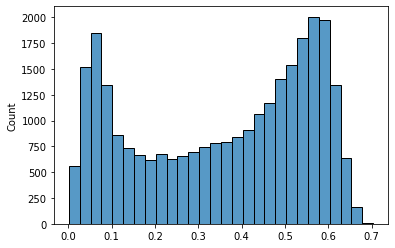

In [53]:
sns.histplot(distances[:,0])

In [22]:
submission = pd.read_csv('/root/data/sample_submission.csv')
submission

,image,predictions
0,000110707af0ba.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
1,0006287ec424cb.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
2,000809ecb2ccad.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
3,00098d1376dab2.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
4,000b8d89c738bd.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
...,...,...
27951,fff6ff1989b5cd.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
27952,fff8fd932b42cb.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
27953,fff96371332c16.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
27954,fffc1c4d3eabc7.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...


In [24]:
submission.predictions[0]

'37c7aba965a5 114207cab555 a6e325d8e924 19fbb960f07d new_individual'

# 2번 : 트레인데이터에 대한 test추론 후  
# distance (id) 평균값, 최댓값으로 앙상블

가정 : 많이 모여있는건 의미가 없다. 결국 distance만 의미가 있다.

In [846]:
from joblib import Parallel, delayed

In [859]:
def make_test_preds(fold):
# fold = i
    results_test = np.array([])
    train_single, valid_single = stratified_kfold(df=df_single, fold=fold, n_split=config.n_split, seed=config.seed, target_col='species')
    train_others, valid_others = stratified_kfold(df=df_others, fold=fold, n_split=config.n_split, seed=config.seed, target_col='individual_id')
    train_single_indices = np.take(df_single.index.to_numpy(), train_single) # 실제 index    
    train_others_indices = np.take(df_others.index.to_numpy(), train_others)
    valid_single_indices = np.take(df_single.index.to_numpy(), valid_single)
    valid_others_indices = np.take(df_others.index.to_numpy(), valid_others)

    full_train_indices = np.sort(np.concatenate((train_single_indices, train_others_indices), axis=0))
    full_valid_indices = np.sort(np.concatenate((valid_single_indices, valid_others_indices), axis=0))

    embeds_train = sorted(glob('/root/embeddings/220329_effn_m/*train*'))
    embeds_test = sorted(glob('/root/embeddings/220329_effn_m/*test*'))
    embed_train = torch.load(embeds_train[fold]).numpy()
    embed_test = torch.load(embeds_test[fold]).numpy()
    print('1')
    neigh = NearestNeighbors(n_neighbors=1, metric='cosine')
    neigh.fit(embed_train[full_train_indices])
    #     distance1, indices1 = neigh.kneighbors(embed_train[valid_single_indices], n_neighbors=20, return_distance=True) # 80 %에 해당하는 index
    #     distance2, indices2 = neigh.kneighbors(embed_train[valid_others_indices], n_neighbors=20, return_distance=True)

    #     results1 = make_result_dict(indices1, distance1, full_train_indices)
    #     results2 = make_result_dict(indices2, distance2, full_train_indices)

    #     np.append(results1_all, results1)
    #     np.append(results2_all, results2)

    distance3, indices3 = neigh.kneighbors(embed_test, n_neighbors=3, return_distance=True)
    print('2')
    results3 = make_result_dict(indices3, distance3, full_train_indices)
    results_test = np.append(results_test, results3, axis=0)
    return results_test

In [863]:
r = Parallel(n_jobs=5, backend="threading")(delayed(make_test_preds)(i) for i in range(5))

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


1
1
1
1
1


KeyboardInterrupt: 

In [53]:
results1_all = np.array([])
results2_all = np.array([])

results_test = np.array([])
for i in range(5): # individual_id 와 distance들어있는 dict 생성
    fold = i
    train_single, valid_single = stratified_kfold(df=df_single, fold=fold, n_split=config.n_split, seed=config.seed, target_col='species')
    train_others, valid_others = stratified_kfold(df=df_others, fold=fold, n_split=config.n_split, seed=config.seed, target_col='individual_id')
    train_single_indices = np.take(df_single.index.to_numpy(), train_single) # 실제 index    
    train_others_indices = np.take(df_others.index.to_numpy(), train_others)
    valid_single_indices = np.take(df_single.index.to_numpy(), valid_single)
    valid_others_indices = np.take(df_others.index.to_numpy(), valid_others)

    full_train_indices = np.sort(np.concatenate((train_single_indices, train_others_indices), axis=0))
    full_valid_indices = np.sort(np.concatenate((valid_single_indices, valid_others_indices), axis=0))

    embeds_train = sorted(glob('/root/embeddings/220329_effn_m/*train*'))
    embeds_test = sorted(glob('/root/embeddings/220329_effn_m/*test*'))
    embed_train = torch.load(embeds_train[fold]).numpy()
    embed_test = torch.load(embeds_test[fold]).numpy()
    
    neigh = NearestNeighbors(n_neighbors=1, metric='cosine')
    neigh.fit(embed_train) # [full_train_indices])
    
#     distance1, indices1 = neigh.kneighbors(embed_train[valid_single_indices], n_neighbors=20, return_distance=True) # 80 %에 해당하는 index
#     distance2, indices2 = neigh.kneighbors(embed_train[valid_others_indices], n_neighbors=20, return_distance=True)
    
#     results1 = make_result_dict(indices1, distance1, full_train_indices)
#     results2 = make_result_dict(indices2, distance2, full_train_indices)
    
#     np.append(results1_all, results1)
#     np.append(results2_all, results2)
    
    distance3, indices3 = neigh.kneighbors(embed_test, n_neighbors=300, return_distance=True)
    results3 = make_result_dict(indices3, distance3, full_train_indices)
    results_test = np.append(results_test, results3, axis=0)

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [690]:
distance3

array([[0.11542571, 0.1336509 , 0.1375047 , ..., 0.63547   , 0.66773605,
        0.70595217],
       [0.06559956, 0.07716995, 0.08057189, ..., 0.16244727, 0.16870296,
        0.17480648],
       [0.5455131 , 0.5487976 , 0.5654436 , ..., 0.65098083, 0.65161705,
        0.65746224],
       ...,
       [0.53554136, 0.55506235, 0.5677161 , ..., 0.67394906, 0.6786909 ,
        0.6800815 ],
       [0.49854624, 0.5215736 , 0.52992654, ..., 0.6867889 , 0.6881016 ,
        0.68815744],
       [0.48455268, 0.59511006, 0.6244451 , ..., 0.703756  , 0.70421547,
        0.70640785]], dtype=float32)

In [683]:
results_test

array([], dtype=float64)

In [512]:
len(results1_all[0])

38163

In [511]:
len(results2_all[0])

0

In [513]:
len(results_test[0])

0

In [ ]:
!ls

In [324]:
fold = 0
train_single, valid_single = stratified_kfold(df=df_single, fold=fold, n_split=config.n_split, seed=config.seed, target_col='species')
train_others, valid_others = stratified_kfold(df=df_others, fold=fold, n_split=config.n_split, seed=config.seed, target_col='individual_id')
train_single_indices = np.take(df_single.index.to_numpy(), train_single) # 실제 index    
train_others_indices = np.take(df_others.index.to_numpy(), train_others)
valid_single_indices = np.take(df_single.index.to_numpy(), valid_single)
valid_others_indices = np.take(df_others.index.to_numpy(), valid_others)

full_train_indices = np.sort(np.concatenate((train_single_indices, train_others_indices), axis=0))
full_valid_indices = np.sort(np.concatenate((valid_single_indices, valid_others_indices), axis=0))

embeds_train = sorted(glob('/root/embeddings/220329_effn_m/*train*'))
embeds_test = sorted(glob('/root/embeddings/220329_effn_m/*test*'))
embed_train = torch.load(embeds_train[fold]).numpy()

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [326]:
neigh = NearestNeighbors(n_neighbors=1, metric='cosine')
neigh.fit(embed_train[full_train_indices])

In [479]:
distance1, indices1 = neigh.kneighbors(embed_train[valid_single_indices], n_neighbors=300, return_distance=True) # 80 %에 해당하는 index
distance2, indices2 = neigh.kneighbors(embed_train[valid_others_indices], n_neighbors=300, return_distance=True)

In [671]:
df.iloc[full_train_indices]

,image,species,individual_id
0,00021adfb725ed.jpg,0,0
1,000562241d384d.jpg,1,1
2,0007c33415ce37.jpg,2,2
3,0007d9bca26a99.jpg,3,3
4,00087baf5cef7a.jpg,1,4
...,...,...,...
51028,fff639a7a78b3f.jpg,4,96
51029,fff8b32daff17e.jpg,17,1482
51030,fff94675cc1aef.jpg,7,8220
51031,fffbc5dd642d8c.jpg,4,13202


In [670]:
df.iloc[full_train_indices].values[0]

array(['00021adfb725ed.jpg', 0, 0], dtype=object)

In [52]:
def make_result_dict(indices, distance, full_train_indices):
    results = np.array([])
    for n, (g_i, g_d) in tqdm(enumerate(zip(indices, distance))):
        # print(g_i)
        result_dict = defaultdict(lambda :1e9)
        # if n == 3:
        for idx, dis in zip(g_i, g_d):
            df_tr = df.individual_id.values[:][idx] # [full_train_indices][idx]
            # spe, ind = df_tr[1], df_tr[2]
            # print(spe, ind)
            result_dict[df_tr] = min(result_dict[df_tr], dis)# summation + dis
        # for k in result_dict:
        #     c, d = result_dict[k]
        #     result_dict[k] = d
        results = np.append(results, result_dict)
    return results

In [ ]:
results1 = make_result_dict(indices1, distance1)
results2 = make_result_dict(indices2, distance2)

In [483]:
distance_1, indices_1 = [i.values() for i in results1], [i.keys() for i in results1]
distance_2, indices_2 = [i.values() for i in results2], [i.keys() for i in results2]

In [484]:
distance_1fold0 = []
for i in distance_1:
    distance_1fold0.append(list(i)[0])
indices_1fold0 = []
for i in indices_1:
    indices_1fold0.append(list(i)[0])
distance_1fold0 = np.array(distance_1fold0)
indices_1fold0 = np.array(indices_1fold0)

In [485]:
distance_2fold0 = []
for i in distance_2:
    distance_2fold0.append(list(i)[0])
indices_2fold0 = []
for i in indices_2:
    indices_2fold0.append(list(i)[0])
distance_2fold0 = np.array(distance_2fold0)
indices_2fold0 = np.array(indices_2fold0)

In [486]:
neigh_preds = deepcopy(indices_2fold0) # k neighbor 예측값
neigh_trues = df.individual_id[valid_others_indices].values
correct_ = (neigh_preds == neigh_trues) # neigh 예측값중 맞은 index
wrong_ = (neigh_preds != neigh_trues)

In [487]:
(neigh_trues == neigh_preds).sum()/ len(neigh_trues)

0.7792938360263315

In [488]:
correct_ = (neigh_preds == neigh_trues)
wrong_ = (neigh_preds != neigh_trues)

In [489]:
value = 1e9
best = 0
best_x = 0
best_y = 0
best_z = 0

value_ = 1e9 # 양방향 최소 차이
best_ = 0
best_x_ = 0
best_y_ = 0
for i in np.arange(0., 0.8, 0.001):
    thr = i # 0.455
    x,y,z = (distance_2fold0[:][correct_] > thr).sum(), (distance_2fold0[:][wrong_] < thr).sum(), (distance_1fold0 < thr).sum()
    if value > x+y+z:
        value = (x+y+z)
        best_x = x
        best_y = y
        best_z = z
        best = thr
    if value_ > x+y:
        value_ = x+y
        best_x_ = x
        best_y_ = y
        best_ = thr
best_, value_, (best_x_, best_y_), best, value, (best_x, best_y, best_z)

(0.482, 957, (409, 548), 0.443, 1107, (622, 379, 106))

# max, mean, 실패 / min 쓰자..
fold0 thr : "only others" 0.489, 971, (448, 523) top2,3 164, 84 "total" 0.449, 1135, (689, 348, 98)
fold1 thr : "only others" 0.473 983, (490, 493) top2,3 145, 91 "total" 0.453 1101, (582, 391)
fold2 thr : "only others" 0.476 top2,3 127, 89 (488, 487)      "total" 0.452 1114, (598, 394)
fold3 thr : "only others" 0.472 top2,3 145, 76 (457, 461)      "total" 0.440 1066, (643, 335)
fold4 thr : "only others" 0.469 1031 (517, 514) top2,3 138, 79 "total" 0.461 1176, (554, 485)

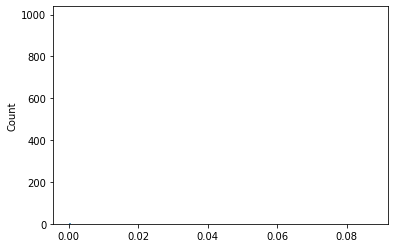

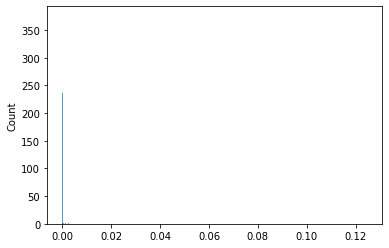

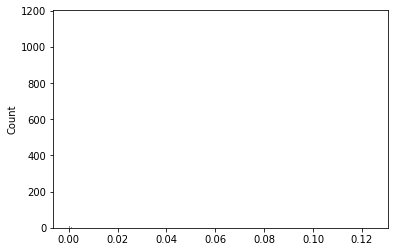

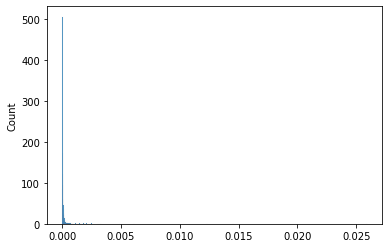

In [444]:
sns.histplot(distance_2fold0[correct_])
plt.show()
sns.histplot(distance_2fold0[wrong_])
plt.show()
sns.histplot(distance_2fold0)
plt.show()
sns.histplot(distance_1fold0)
plt.show()

In [490]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
val_targets = []
val_embeddings = []
for valid_index in tqdm(full_valid_indices):#(VALIDATION_FILENAMES):
    print(valid_index)
    embeddings = get_embeddings_np(filename,'val')
    # targets = get_targets(filename)
    # ids = get_ids(filename)
    # distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
    # test_ids.append(ids)
    # test_nn_idxs.append(idxs)
    # test_nn_distances.append(distances)
    # val_embeddings.append(embeddings)
    # val_targets.append(targets)
# test_nn_distances = np.concatenate(test_nn_distances)
# test_nn_idxs = np.concatenate(test_nn_idxs)
# test_ids = np.concatenate(test_ids)
# val_embeddings = np.concatenate(val_embeddings)
# val_targets = np.concatenate(val_targets)

1
2
13
31
35
43
46
47
48
51
56
57
61
67
69
73
80
81
85
87
102
105
111
112
117
122
124
125
126
127
132
134
136
140
142
147
149
150
171
173
174
175
178
199
202
220
227
228
231
232
246
248
252
275
279
287
300
311
314
318
321
322
330
334
336
338
340
341
349
353
355
356
365
369
374
383
388
391
400
405
407
416
418
420
433
434
447
450
451
457
466
471
473
481
482
494
498
500
503
504
511
515
516
524
525
527
530
531
533
537
538
542
550
566
568
571
574
579
583
587
590
591
593
595
604
615
617
623
625
627
631
635
649
652
658
660
663
667
684
689
690
693
702
704
711
714
715
738
743
754
772
774
781
787
790
794
798
800
805
807
810
811
828
829
841
843
845
850
853
860
862
864
871
872
876
880
881
883
889
894
912
918
920
929
930
931
941
943
945
947
951
969
989
990
992
993
998
1003
1006
1015
1020
1021
1025
1026
1031
1036
1041
1045
1065
1072
1082
1090
1092
1096
1104
1111
1122
1124
1126
1129
1131
1136
1142
1161
1162
1166
1171
1174
1175
1176
1186
1190
1195
1200
1202
1212
1220
1226
1229
1232
1237
1239
1258
1269

In [508]:
len(results2_all[0])

0

In [701]:
27956*5

139780

In [20]:
len(results_test)

139780

In [22]:
l = len(results_test)//5
l

27956

In [716]:
results_test

array([defaultdict(<function make_result_dict.<locals>.<lambda> at 0x7f49849d4af0>, {1971: 1000000000.0, 1549: 0.7978273, 7890: 1000000000.0, 3247: 1000000000.0, 3367: 1000000000.0, 1673: 1000000000.0, 509: 1000000000.0, 963: 1000000000.0, 1958: 1000000000.0, 4871: 1000000000.0, 1290: 1000000000.0, 7976: 1000000000.0, 4198: 1000000000.0, 1259: 1000000000.0, 7347: 1000000000.0, 418: 1000000000.0, 21: 1000000000.0, 651: 1000000000.0, 1863: 1000000000.0, 13250: 1000000000.0, 3966: 1000000000.0, 13834: 1000000000.0, 2826: 1000000000.0, 6707: 1000000000.0, 8389: 1000000000.0, 678: 1000000000.0, 269: 1000000000.0, 357: 1000000000.0, 8970: 1000000000.0, 2803: 1000000000.0, 11015: 1000000000.0, 9322: 1000000000.0, 15480: 1000000000.0, 15218: 1000000000.0, 998: 1000000000.0, 497: 1000000000.0, 5801: 1000000000.0, 10982: 1000000000.0, 8003: 1000000000.0, 6996: 1000000000.0, 3122: 1000000000.0, 3413: 1000000000.0, 7241: 1000000000.0, 14181: 1000000000.0, 10260: 1000000000.0, 504: 1000000000.0, 18

In [54]:
results = []
for fold0,fold1,fold2,fold3,fold4 in zip(results_test[:l], results_test[l:l*2], results_test[2*l:3*l], results_test[3*l:4*l], results_test[4*l:]):
    tmp_dict = defaultdict(lambda : [0,0]) # cnt, value
    for fold_ in (fold0,fold1,fold2,fold3,fold4):
        for k in fold_:
            # print(k, fold_[k])
            if isinstance(fold_[k], tuple):
                continue
            tmp_dict[k][0] += 1
            tmp_dict[k][1] += fold_[k]
    for ke in tmp_dict:
        
        tmp_dict[ke] = tmp_dict[ke][1] / tmp_dict[ke][0]
    # print(tmp_dict)
    results.append(tmp_dict)

In [55]:
check_dis = []

for i in results:
    for k in i:
        check_dis.append(i[k])
        break
    # break

<AxesSubplot:ylabel='Count'>

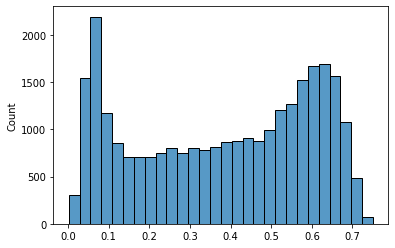

In [56]:
sns.histplot(check_dis)

In [613]:
submission['predictions'][0]

'37c7aba965a5 114207cab555 a6e325d8e924 19fbb960f07d new_individual'

In [714]:
sorted(i.items(), key=lambda x:x[1])

[(1549, 0.7947786450386047),
 (7313, 1000000000.0),
 (8978, 1000000000.0),
 (13680, 1000000000.0),
 (3163, 1000000000.0),
 (15429, 1000000000.0),
 (1042, 1000000000.0),
 (15025, 1000000000.0),
 (10298, 1000000000.0),
 (13687, 1000000000.0),
 (15383, 1000000000.0),
 (4240, 1000000000.0),
 (7608, 1000000000.0),
 (13952, 1000000000.0),
 (9939, 1000000000.0),
 (10086, 1000000000.0),
 (4265, 1000000000.0),
 (6872, 1000000000.0),
 (1884, 1000000000.0),
 (4196, 1000000000.0),
 (12987, 1000000000.0),
 (11862, 1000000000.0),
 (9561, 1000000000.0),
 (5585, 1000000000.0),
 (2284, 1000000000.0),
 (1053, 1000000000.0),
 (15307, 1000000000.0),
 (1453, 1000000000.0),
 (5859, 1000000000.0),
 (12859, 1000000000.0),
 (1537, 1000000000.0),
 (12165, 1000000000.0),
 (798, 1000000000.0),
 (8495, 1000000000.0),
 (5698, 1000000000.0),
 (2845, 1000000000.0),
 (1019, 1000000000.0),
 (9521, 1000000000.0),
 (14286, 1000000000.0),
 (6029, 1000000000.0),
 (3144, 1000000000.0),
 (7731, 1000000000.0),
 (6302, 1000000

In [67]:
thr = 0.556
predictions = []
for i in results:
    
    key_list, distance_list = [], []
    tmp = []
    new_ind_check = False
    for idx, (key, value) in enumerate(sorted(i.items(), key=lambda x:x[1])): # 한 이미지
        if value > thr and (not new_ind_check):
            tmp.append('new_individual')
            new_ind_check=True
            tmp.append(idx2individual[key])
        elif len(tmp) < 5:
            tmp.append(idx2individual[key])
        else:
            continue
    if len(tmp) < 5 and not new_ind_check:
        tmp.append('new_individual')
        # print(key, value, tmp)
    tmp_str = ' '.join(tmp)
    # print(tmp_str)
    predictions.append(tmp_str)
    # break

In [68]:
cnt = 0
for i in predictions:
    if i.split()[0] == 'new_individual':
        cnt += 1
cnt

6274

In [69]:
submission = pd.read_csv('/root/data/sample_submission.csv')

In [70]:
submission['predictions'] = predictions

In [71]:
submission

,image,predictions
0,000110707af0ba.jpg,fbe2b15b5481 5a199d197c45 af40e728a460 new_ind...
1,0006287ec424cb.jpg,1424c7fec826 ea8160d46f8f new_individual 5d00f...
2,000809ecb2ccad.jpg,9984825308e3 1ce3ba6a3c29 1cd37d6e3090 new_ind...
3,00098d1376dab2.jpg,c4274d90be60 71a37a272638 557406f121e6 new_ind...
4,000b8d89c738bd.jpg,cf500d3874bc new_individual 56637d420170 d4d2c...
...,...,...
27951,fff6ff1989b5cd.jpg,734573d54bef 843297d1983b new_individual 712f2...
27952,fff8fd932b42cb.jpg,new_individual ac378381b869 f7344c0911b5 aa181...
27953,fff96371332c16.jpg,dc4082105594 new_individual 2fad3a13934d 8949d...
27954,fffc1c4d3eabc7.jpg,e7f9e93184b9 new_individual a8fe10f7b3e0 d85f2...


In [72]:
submission.to_csv('submission_thr556_full.csv', index=False)